# Jul 9th, 2022 (Fig-6 mem plots)

**Motivation**: + Bar, Pie, etc <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig6_Members'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig6_Members

## Prepare (512)

In [3]:
mice = Mice(nn)

kws_show = {
    'vmin': 0.1,
    'vmax': 1.0,
    'interp': 'none',
    'cmap': 'Spectral',
    'mask_thresh': 0.001,
    'contour_width': 0.2,
    'contour_alpha': 0.7,
    'contour_coarse': False,
    'add_disjoint': False,
    'add_title': True,
}

## Results

### K = 7; use prune

In [4]:
%%time

num_k = 7
results = member_results(
    mice=mice,
    num_k=num_k,
    use_prune=True,
    merge_thres=0.372,
    global_order=('infer', False),
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 12.4 s, sys: 3.32 s, total: 15.7 s
Wall time: 15.8 s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'mu_vals',
    'members',
    'reject',
    'scores'
]

In [5]:
from figures.fig_mem import mk_member_cmap
spectral, accent = mk_member_cmap()

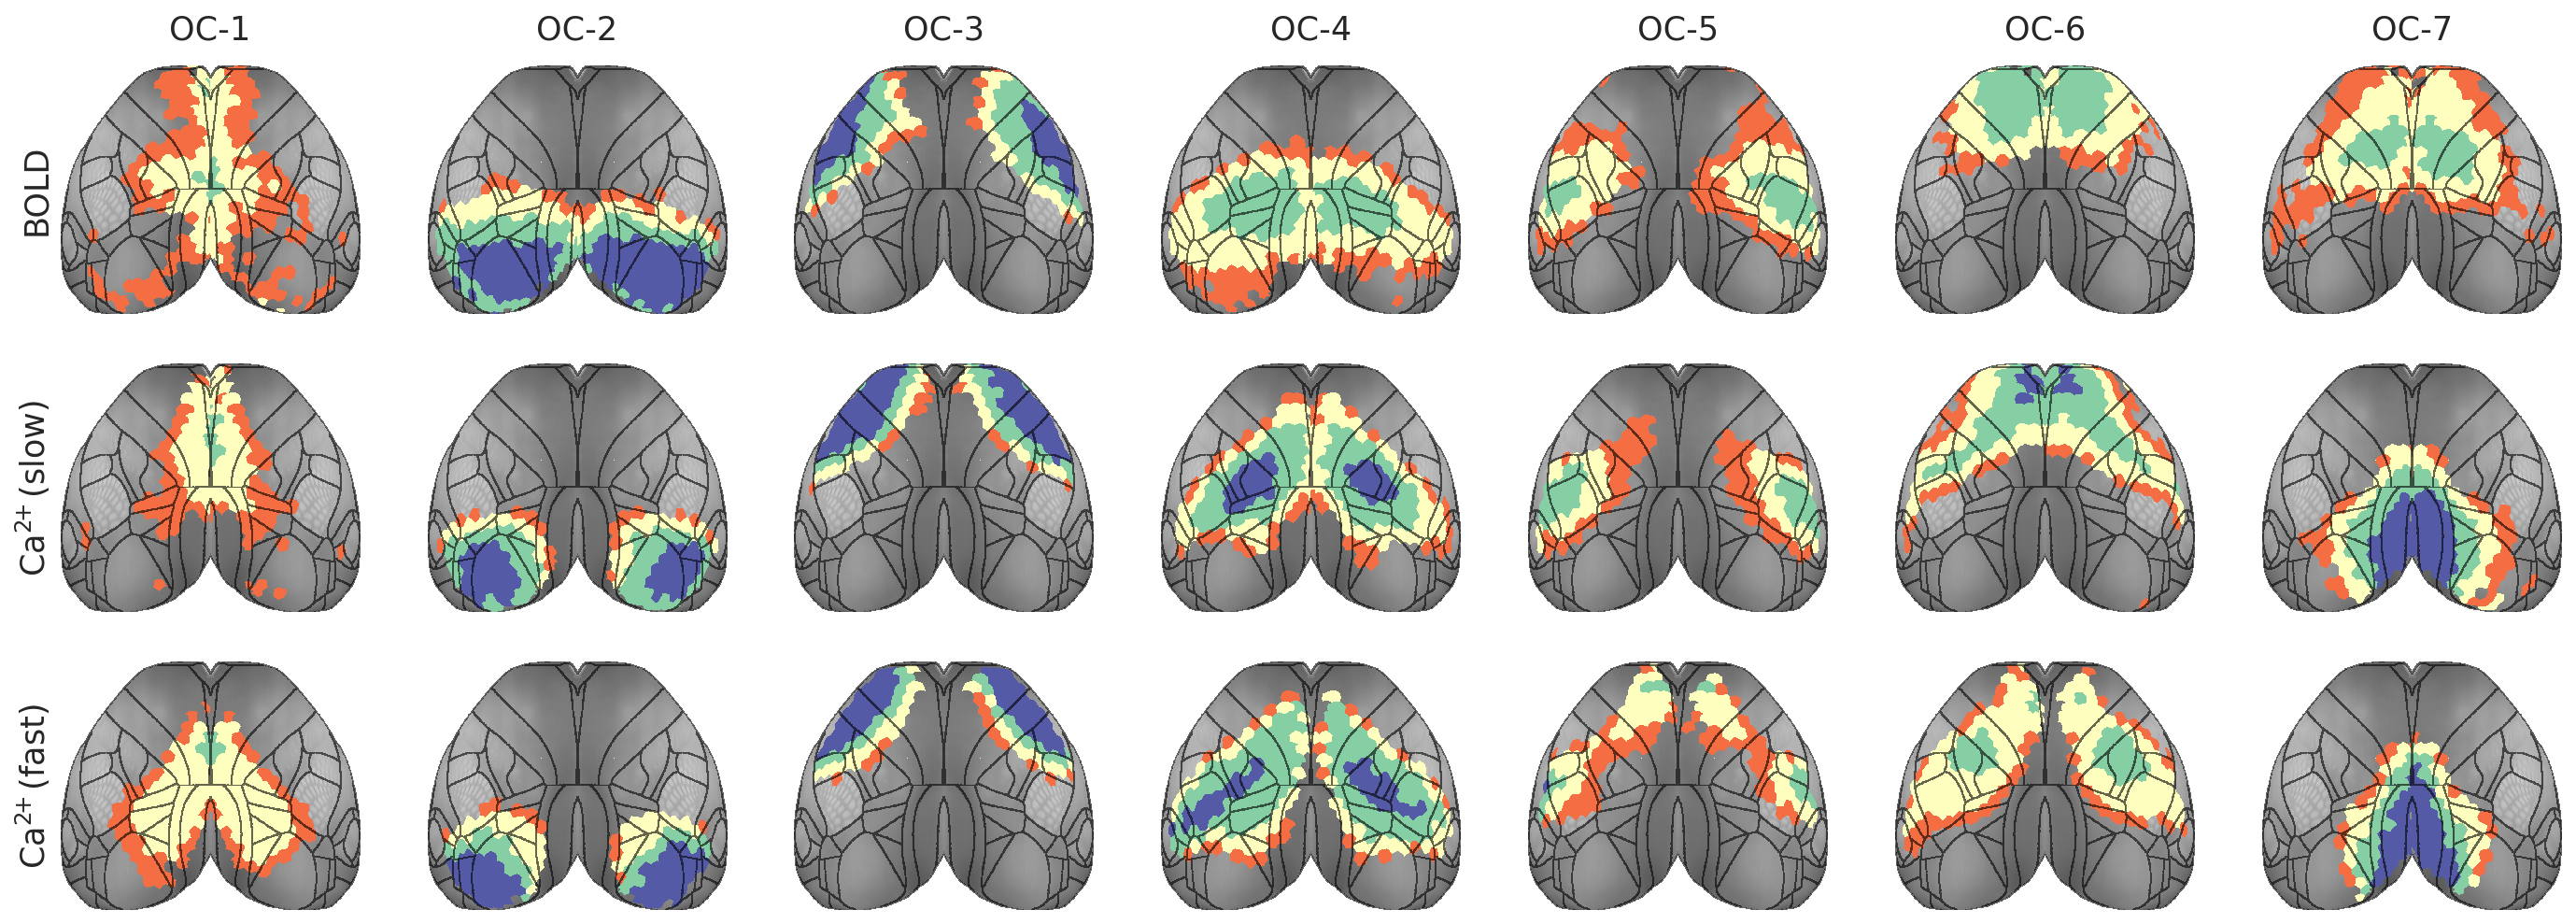

In [6]:
kws_show['vmin'] = 1
kws_show['vmax'] = len(results['mu_vals'])
kws_show['contour_cmap'] = 'Greys_r'
kws_show['contour_alpha'] = 0.6
kws_show['cmap'] = spectral

_ = bt.show(results['members'], dpi=150, **kws_show)

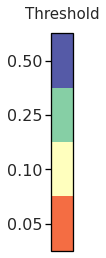

In [7]:
fig, cax, cbar = cbar_only(spectral, tick_position='left')
cax.set_title('Threshold', fontsize=15, y=1.04, rotation=0)
cax.tick_params(labelsize=16)
cax.yaxis.set(
    ticks=[(i + 0.5) / len(results['mu_vals']) for i in range(len(results['mu_vals']))],
    ticklabels=[f"{mu:0.02f}" for
                mu in results['mu_vals']],
)
fig

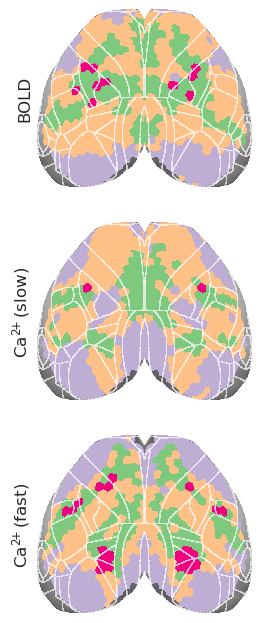

In [8]:
mu = 0.1

_ = bt.show(
    data={
        mode: d1[mu]['node_mem'] for
        mode, d1 in results['scores'].items()},
    vmin=1,
    vmax=4,
    cmap=accent,
    interp='none',
    mask_thresh=0.01,
    contour_coarse=False,
    contour_cmap='Greys',
    contour_alpha=0.7,
    figsize=(4.5, 8),
    dpi=100,
)

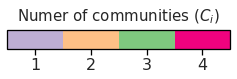

In [9]:
fig, cax, cbar = cbar_only(accent, vertical=False)
cax.set_title('Numer of communities ($C_i$)', y=1.2, fontsize=15)
cax.tick_params(labelsize=16)
cax.xaxis.set(
    ticks=[(i + 0.5) / 4 for i in range(4)],
    ticklabels=range(1, 4 + 1),
)
fig

## Bar plot

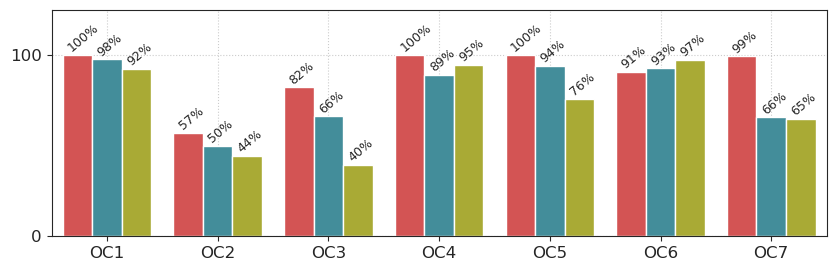

In [10]:
from figures.fig_mem import scores_bar as go
fig, _ = go(results)

fig.savefig(pjoin(fig_dir, f'bar_K{num_k}.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, f'bar_K{num_k}.png'), **kws_fig)

## Pie

In [11]:
mode2lbl = {
    BOLD: 'BOLD',
    CAS: 'CAS',
    CAF: 'CAF',
}

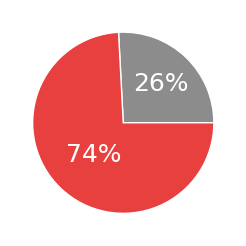

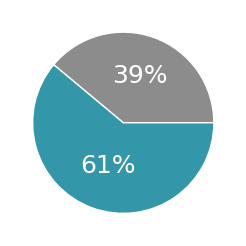

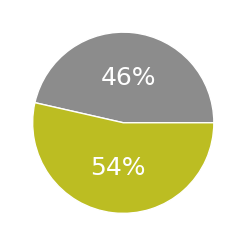

In [12]:
from figures.fig_mem import scores_pie as go
figs = go(results)

for mode, f in figs.items():
    f.savefig(pjoin(fig_dir, f'pie_K{num_k}_{mode2lbl[mode]}.pdf'), **kws_fig)
    f.savefig(pjoin(fig_dir, f'pie_K{num_k}_{mode2lbl[mode]}.png'), **kws_fig)
    display(f)

## Mem (column plots)

In [13]:
from figures.fighelper import ctx2ax

save_dir = pjoin(fig_dir, 'Mem')
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig6_Members/Mem

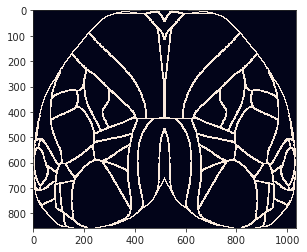

In [14]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

### Spectral

In [15]:
kwargs = {
    'base': bt,
    'vmin': 1,
    'vmax': len(results['mu_vals']),
    'cbar': False,
    'cmap': spectral,
    'contour': contour,
    'contour_alpha': 0.6,
    'contour_cmap': 'Greys_r',
    'interp': 'antialiased',
}

In [16]:
for i in range(num_k):
    fig, axes = create_figure(
        nrows=3,
        ncols=1,
        figsize=(3, 7),
        sharex='all',
        sharey='all',
        tight_layout=False,
        constrained_layout=True,
    )
    for j, (mode, mem) in enumerate(results['members'].items()):
        x = mem[i].copy()
        x[x <= 0] = np.nan
        ctx2ax(x=x, ax=axes[j], **kwargs)
    remove_ticks(axes)
    fig.savefig(pjoin(save_dir, f'OC-{i+1}.png'), **kws_fig)
    plt.close()

### Accent

In [17]:
kwargs = {
    'base': bt,
    'vmin': 1,
    'vmax': len(accent.colors),
    'cbar': False,
    'cmap': accent,
    'contour': contour,
    'contour_alpha': 0.7,
    'contour_cmap': 'Greys',
    'interp': 'antialiased',
}

In [18]:
mu = 0.1
data = {
    mode: d1[mu]['node_mem'] for
    mode, d1 in results['scores'].items()
}
fig, axes = create_figure(
    nrows=3,
    ncols=1,
    figsize=(3, 7),
    sharex='all',
    sharey='all',
    tight_layout=False,
    constrained_layout=True,
)
for j, (mode, c) in enumerate(data.items()):
    x = c.copy()
    x[x <= 0] = np.nan
    ctx2ax(x=x, ax=axes[j], **kwargs)
remove_ticks(axes)
fig.savefig(pjoin(save_dir, 'C.png'), **kws_fig)
plt.close()